In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Mon Jun 13 00:16:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   34C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2010 = db.rm_patent_cn_2010
    db_rm_us_2010 = db.rm_patent_us_2010
    db_rm_de_2010 = db.rm_patent_de_2010

    
except errors.ConnectionFailure as err:
    print(err)

# 2010

## Company數量

In [6]:
data_assignee = db_rm_de_2010.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2010.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2010.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(20)

,company,count
43,ZTE Corp,13
44,ZTE Intelligent IoT Technology Co Ltd,11
40,Xerox Corp,9
11,Chengdu Qinchuan IoT Technology Co Ltd,7
10,Chengdu Monolithic Power Systems Co Ltd,5
22,Institute of Electrical Engineering of CAS,4
15,Datang Mobile Communications Equipment Co Ltd,4
45,Zhejiang University ZJU,3
17,Fujifilm Business Innovation Corp,3
16,Dezhou University,3


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(20)
com_df.reset_index(drop=True, inplace=True)

In [13]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,ZTE Corp,13,2.564949
1,ZTE Intelligent IoT Technology Co Ltd,11,2.397895
2,Xerox Corp,9,2.197225
3,Chengdu Qinchuan IoT Technology Co Ltd,7,1.945910
4,Chengdu Monolithic Power Systems Co Ltd,5,1.609438
5,Institute of Electrical Engineering of CAS,4,1.386294
6,Datang Mobile Communications Equipment Co Ltd,4,1.386294
7,Zhejiang University ZJU,3,1.098612
8,Fujifilm Business Innovation Corp,3,1.098612
9,Dezhou University,3,1.098612


In [14]:
com_ls = list(com_df.company)

## Data

In [15]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2010.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2010.csv")

In [16]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AU,BR,CA,CN,DE,DK,EP,ES,GB,HK,IN,JP,KR,MX,RU,SG,TW,US,ZA
21,Beijing University of Technology,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,Chengdu Monolithic Power Systems Co Ltd,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
39,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,Datang Mobile Communications Equipment Co Ltd,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,Dezhou University,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [17]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [18]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AU,BR,CA,CN,DE,DK,EP,ES,GB,HK,IN,JP,KR,MX,RU,SG,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,
ZTE Corp,0.038462,0.0,0.0,0.500,0.0,0.0,0.115385,0.0,0.0,0.0,0.0,0.115385,0.038462,0.0,0.076923,0.0,0.0,0.115385,0.0
ZTE Intelligent IoT Technology Co Ltd,0.000000,0.0,0.0,1.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Xerox Corp,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.900000,0.0
Chengdu Qinchuan IoT Technology Co Ltd,0.000000,0.0,0.0,1.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
Chengdu Monolithic Power Systems Co Ltd,0.000000,0.0,0.0,0.625,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.250000,0.0


In [19]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [22]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

KeyError: "None of ['company'] are in the columns"

In [23]:
# ccpc_pbc = ccpc2.loc[com_ls,:].copy()
ccpc_pbc = ccpc2[ccpc2.index.isin(com_ls)]
# ccpc_pbc

In [24]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [25]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

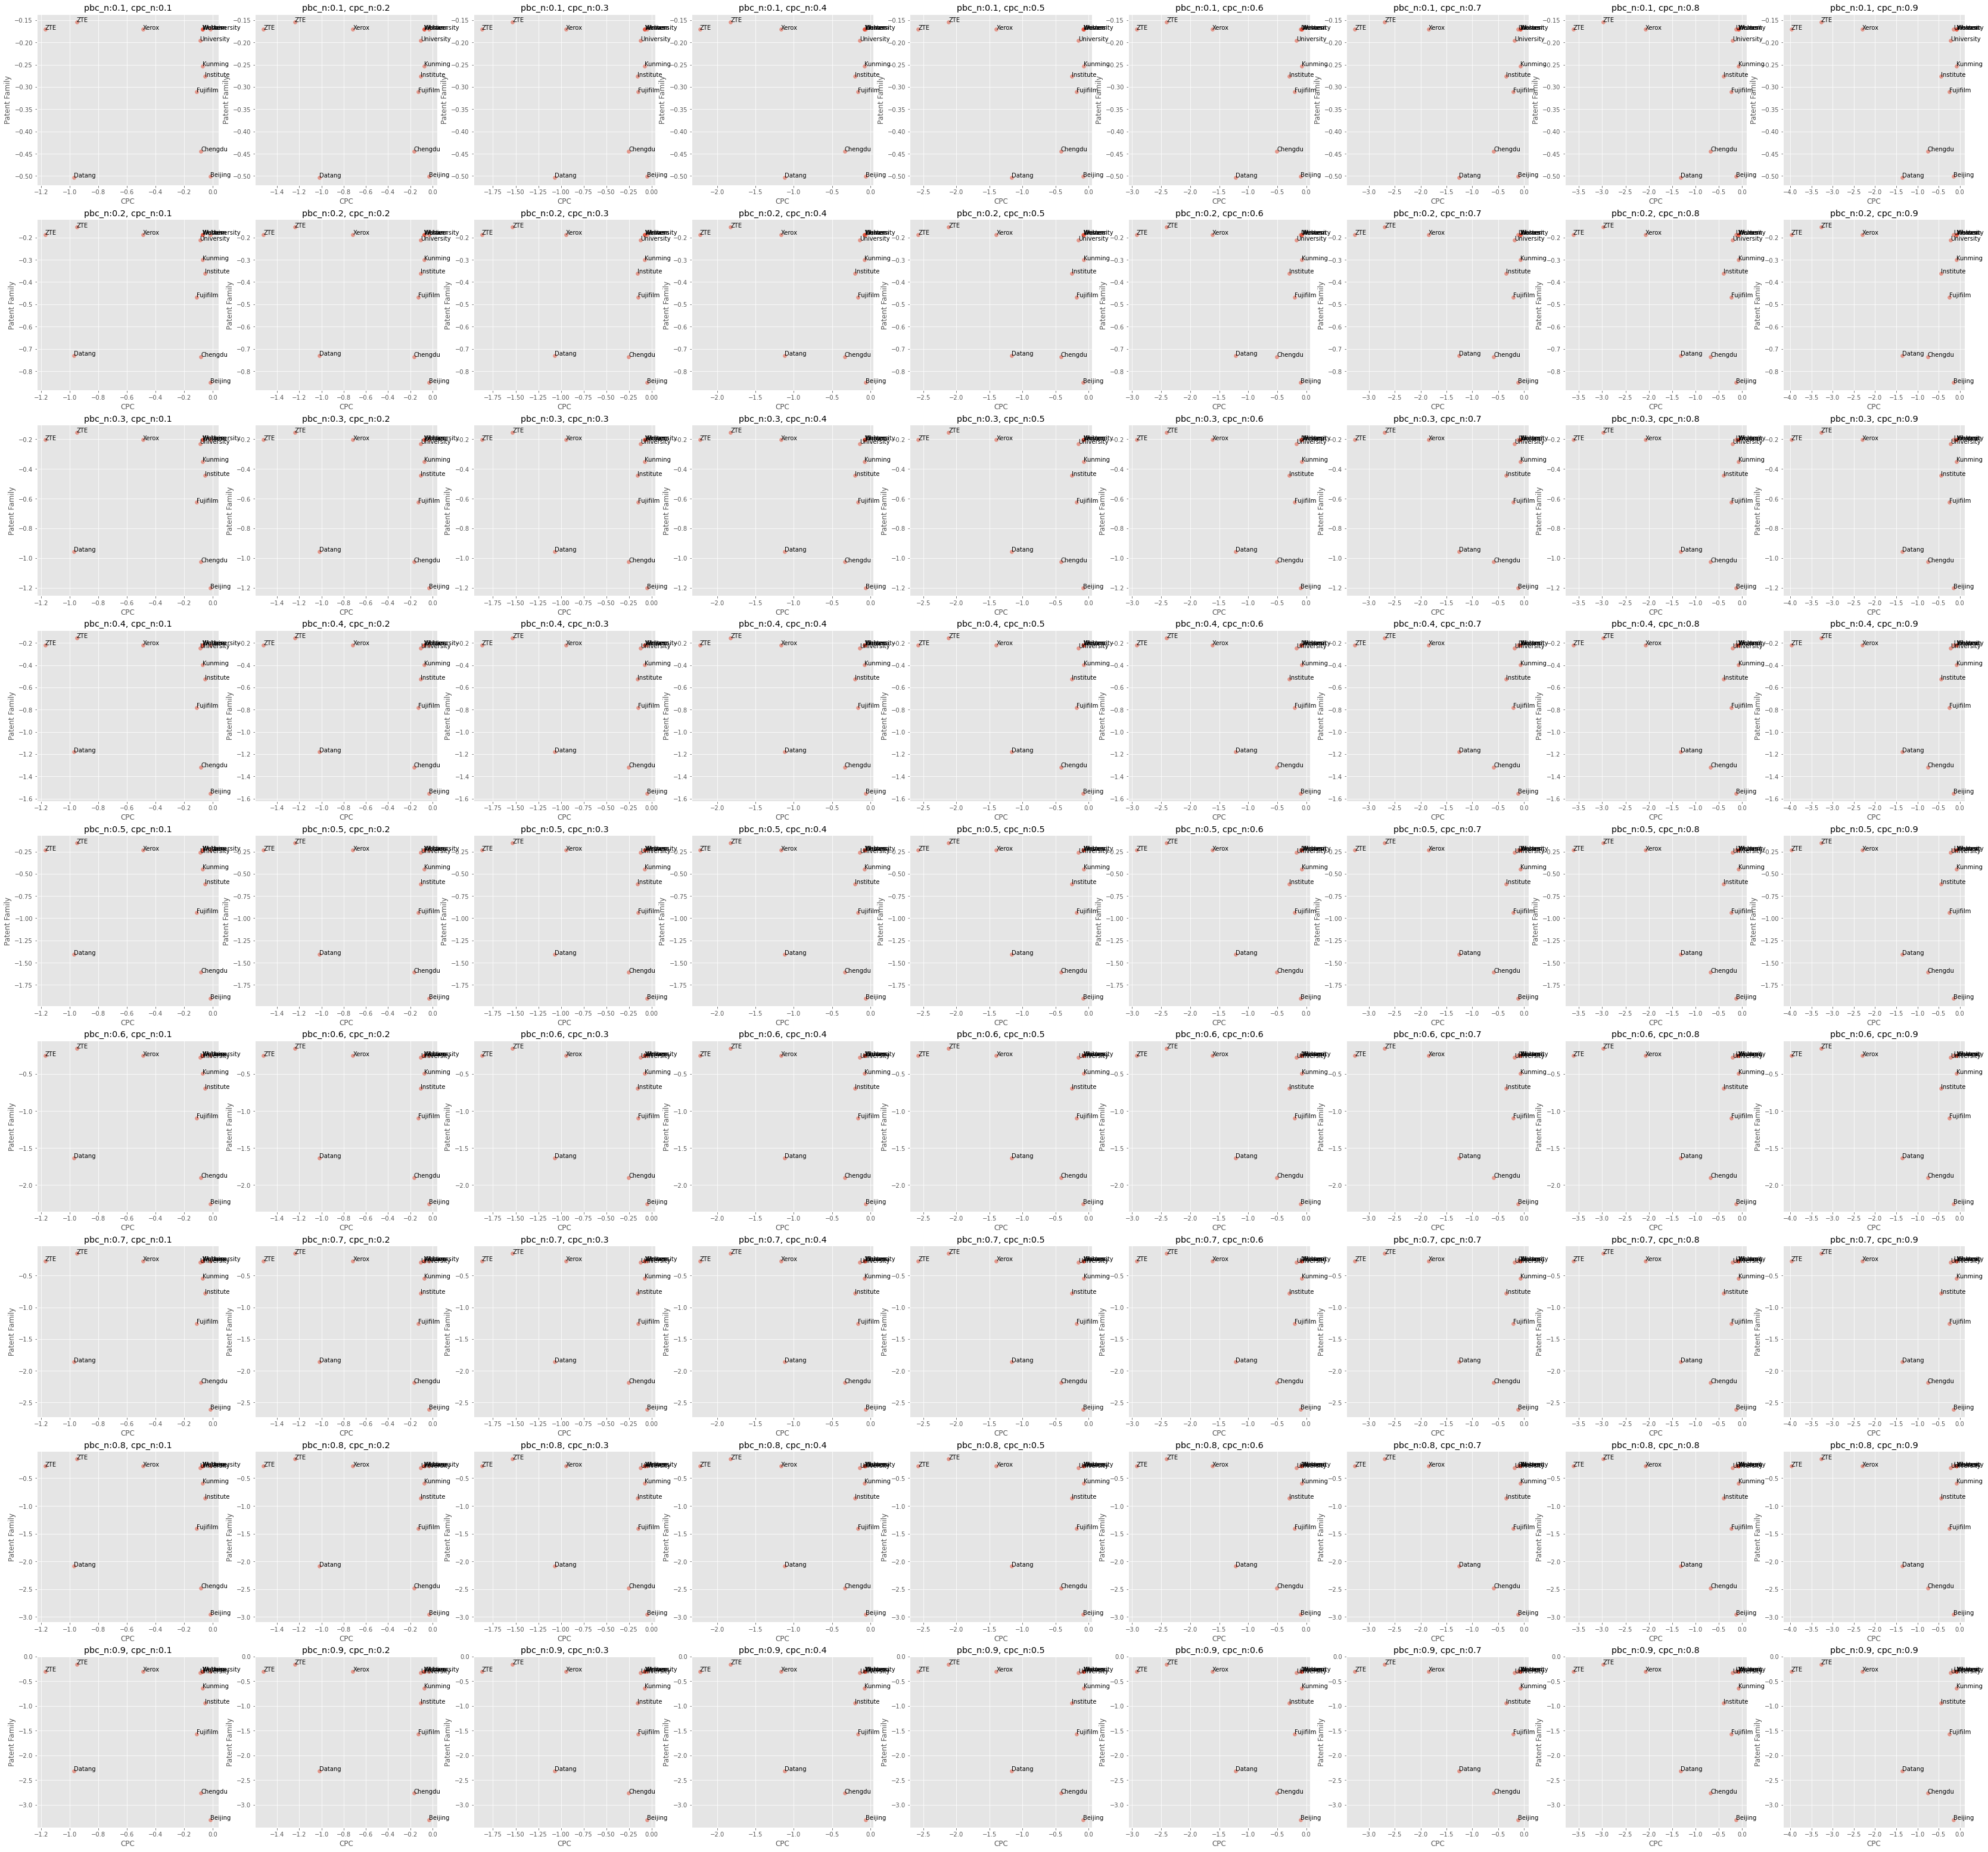

In [26]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2010_1.png'.format(pbc_n))

In [27]:
c_df

,cpc,country
company,,
Beijing University of Technology,0.147962,3.304167
Chengdu Monolithic Power Systems Co Ltd,0.755630,2.769396
Datang Mobile Communications Equipment Co Ltd,1.358334,2.312947
Fujifilm Business Innovation Corp,0.245428,1.566320
Institute of Electrical Engineering of CAS,0.441667,0.947938
Kunming University of Science and Technology,0.074074,0.637536
University of Science and Technology Beijing USTB,0.147962,0.301808
University of Shanghai for Science and Technology,0.222036,0.327449
Western Superconducting Technologies Co Ltd,0.074074,0.301808


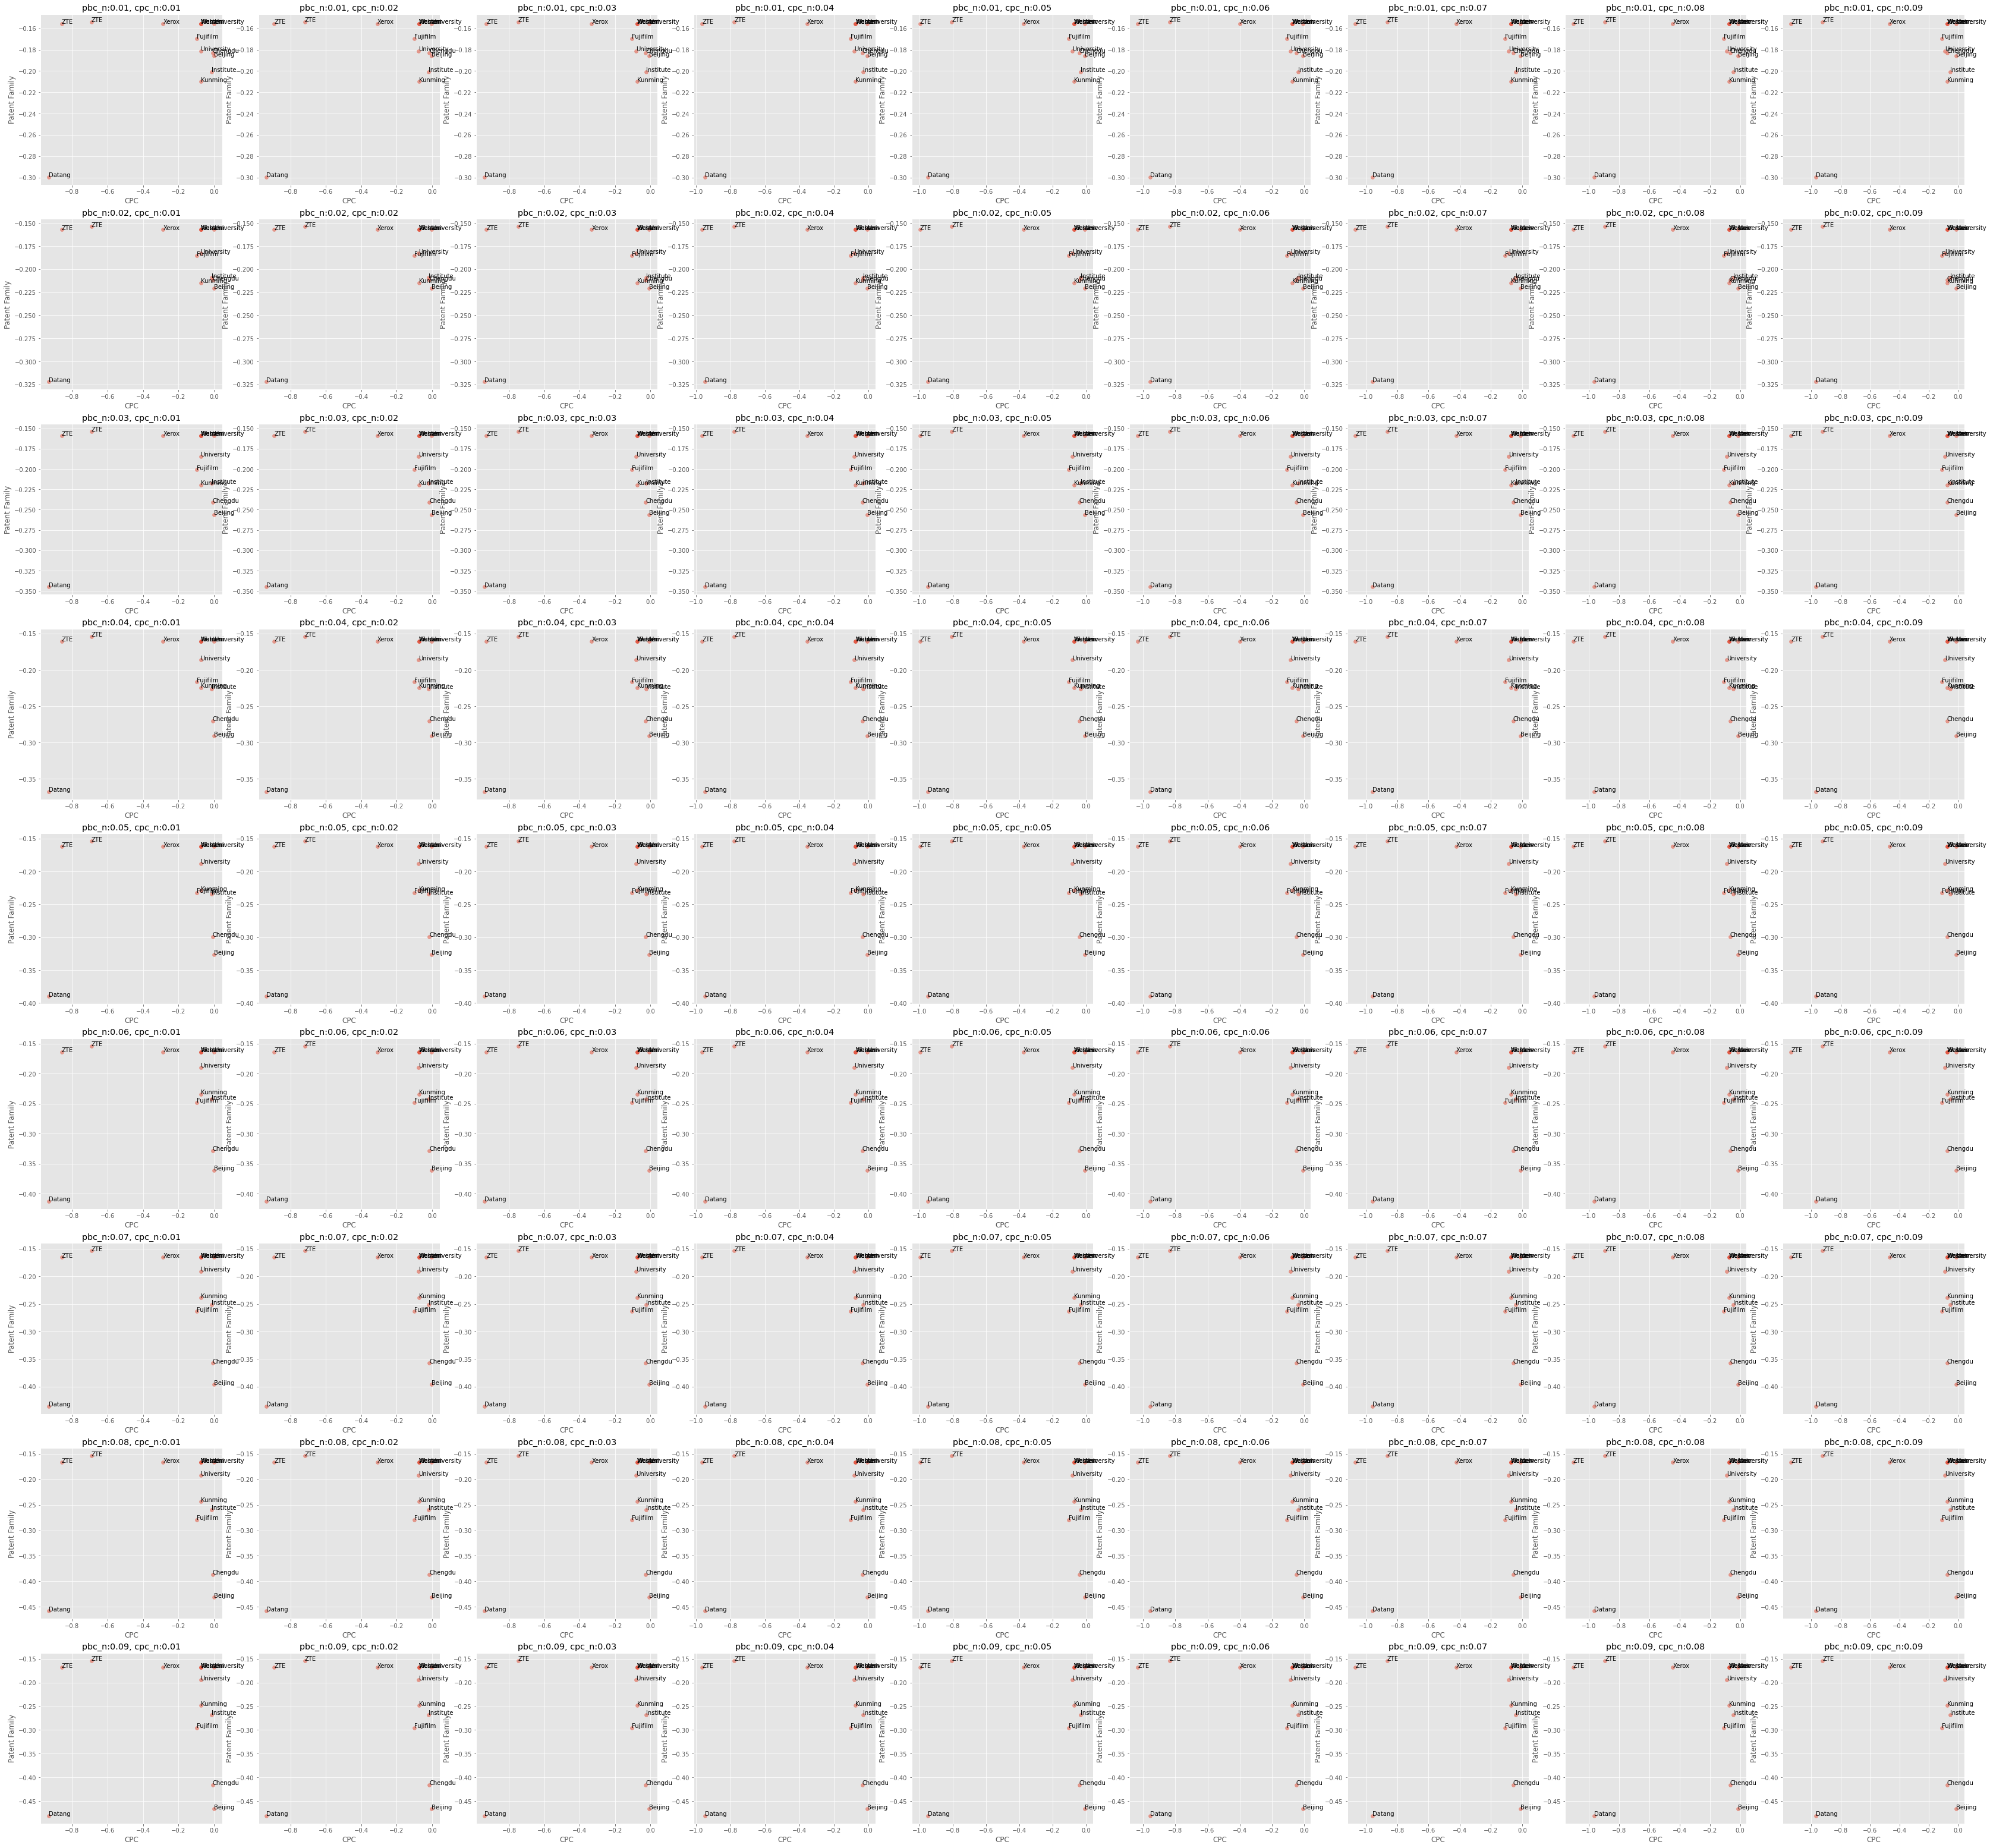

In [28]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2010_2.png'.format(pbc_n))

In [29]:
c_df

,cpc,country
company,,
Beijing University of Technology,0.014796,0.466215
Chengdu Monolithic Power Systems Co Ltd,0.075563,0.415401
Datang Mobile Communications Equipment Co Ltd,0.969167,0.480525
Fujifilm Business Innovation Corp,0.112262,0.295094
Institute of Electrical Engineering of CAS,0.052500,0.267871
Kunming University of Science and Technology,0.074074,0.248369
University of Science and Technology Beijing USTB,0.014796,0.168642
University of Shanghai for Science and Technology,0.088870,0.194283
Western Superconducting Technologies Co Ltd,0.074074,0.168642


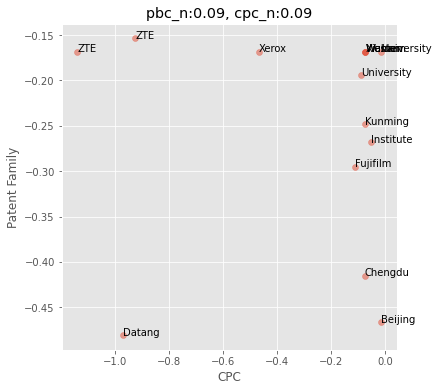

In [30]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [31]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [32]:
competitor_ls

[3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]

In [33]:
list(c_df.index)

['Beijing University of Technology',
 'Chengdu Monolithic Power Systems Co Ltd',
 'Datang Mobile Communications Equipment Co Ltd',
 'Fujifilm Business Innovation Corp',
 'Institute of Electrical Engineering of CAS',
 'Kunming University of Science and Technology',
 'University of Science and Technology Beijing USTB',
 'University of Shanghai for Science and Technology',
 'Western Superconducting Technologies Co Ltd',
 'Wuhan University WHU',
 'Xerox Corp',
 'Xiamen Xindeco IOT Technology Ltd.',
 'ZTE Corp',
 'ZTE Intelligent IoT Technology Co Ltd']